# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# TabNet library
#
from pytorch_tabnet.tab_model import TabNetRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Data handling parameters

In [3]:
# Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [5]:
Lag        =   12
Horizon    =    4

# Data handling

## Import data


In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.41 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-02-19 00:00:00,2.457895
2022-02-19 00:05:00,2.494737
2022-02-19 00:10:00,2.494737


In [8]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [9]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

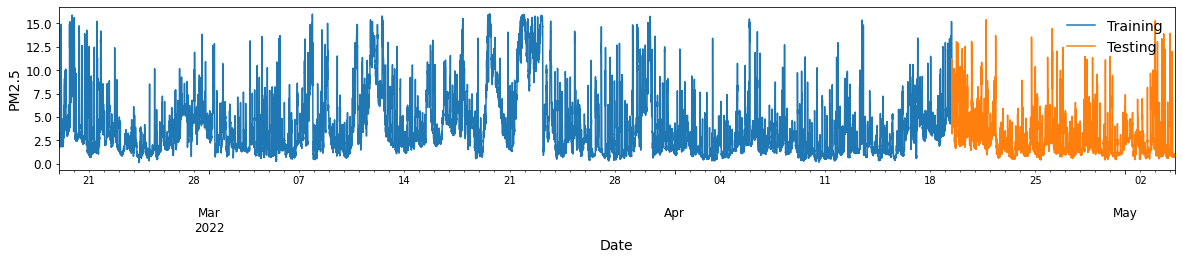

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [11]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [12]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(-df.min().min(), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [13]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [14]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Instances: Lag-d differences
        Instance  = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ][i:(i+Lag-1)]).to_list()
        # Time
        Instance.append( df.index[i+Lag-1].hour + df.index[i+Lag-1].minute / 60) 
        # Current value
        Instance.append( df[ targetSeries ].to_numpy()[i+Lag-1] )

           
        

        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY) )

In [15]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon,)

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 1,)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 4277/4277 [00:01<00:00, 3208.32it/s]

Training instances:     4276
Testing instances:      4277


In [16]:
trainX.shape, trainY.shape

((4276, 13), (4276, 4))

# Forecasting model: TabNet

## Setup model

In [17]:
model = TabNetRegressor(verbose = 1, 
                        seed    = 42)

Device used : cpu


## Training process

In [ ]:
import torch.nn as nn

# Start clock
#
start = time.time()

# Train model
#
model.fit(X_train = trainX, 
          y_train = trainY,
          loss_fn = nn.MSELoss(), # nn.L1Loss(), nn.MSELoss()
          #
          eval_set    = [(testX, testY)],
          batch_size  = 32,
          num_workers = 0,
          patience    = 100, 
          max_epochs  = 2000,
          eval_metric = ['rmse'])

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

epoch 0  | loss: 0.27964 | val_0_rmse: 0.53887 |  0:00:04s
epoch 1  | loss: 0.22108 | val_0_rmse: 0.52835 |  0:00:08s
epoch 2  | loss: 0.21606 | val_0_rmse: 0.52726 |  0:00:12s
epoch 3  | loss: 0.21426 | val_0_rmse: 0.52217 |  0:00:16s
epoch 4  | loss: 0.20923 | val_0_rmse: 0.51664 |  0:00:20s
epoch 5  | loss: 0.20902 | val_0_rmse: 0.52192 |  0:00:24s
epoch 6  | loss: 0.20915 | val_0_rmse: 0.51456 |  0:00:28s
epoch 7  | loss: 0.20643 | val_0_rmse: 0.51808 |  0:00:32s
epoch 8  | loss: 0.2073  | val_0_rmse: 0.50829 |  0:00:35s
epoch 9  | loss: 0.20849 | val_0_rmse: 0.51169 |  0:00:39s
epoch 10 | loss: 0.20604 | val_0_rmse: 0.51075 |  0:00:43s
epoch 11 | loss: 0.20272 | val_0_rmse: 0.51295 |  0:00:47s
epoch 12 | loss: 0.20436 | val_0_rmse: 0.51863 |  0:00:51s
epoch 13 | loss: 0.20539 | val_0_rmse: 0.51536 |  0:00:55s
epoch 14 | loss: 0.20774 | val_0_rmse: 0.52148 |  0:00:59s
epoch 15 | loss: 0.20807 | val_0_rmse: 0.50654 |  0:01:03s
epoch 16 | loss: 0.20552 | val_0_rmse: 0.50745 |  0:01:0

epoch 139| loss: 0.20331 | val_0_rmse: 0.50895 |  0:06:21s
epoch 140| loss: 0.20306 | val_0_rmse: 0.50596 |  0:06:24s
epoch 141| loss: 0.20321 | val_0_rmse: 0.53268 |  0:06:26s
epoch 142| loss: 0.20368 | val_0_rmse: 0.5186  |  0:06:28s
epoch 143| loss: 0.20236 | val_0_rmse: 0.51837 |  0:06:31s
epoch 144| loss: 0.20296 | val_0_rmse: 0.51356 |  0:06:33s
epoch 145| loss: 0.20573 | val_0_rmse: 0.51816 |  0:06:36s
epoch 146| loss: 0.20302 | val_0_rmse: 0.50918 |  0:06:38s
epoch 147| loss: 0.20051 | val_0_rmse: 0.507   |  0:06:41s
epoch 148| loss: 0.202   | val_0_rmse: 0.51186 |  0:06:43s
epoch 149| loss: 0.20337 | val_0_rmse: 0.51368 |  0:06:45s
epoch 150| loss: 0.20249 | val_0_rmse: 0.50553 |  0:06:48s
epoch 151| loss: 0.2018  | val_0_rmse: 0.51014 |  0:06:50s
epoch 152| loss: 0.19958 | val_0_rmse: 0.50813 |  0:06:53s
epoch 153| loss: 0.20343 | val_0_rmse: 0.50662 |  0:06:55s
epoch 154| loss: 0.20112 | val_0_rmse: 0.50578 |  0:06:58s
epoch 155| loss: 0.2008  | val_0_rmse: 0.50525 |  0:07:0

epoch 278| loss: 0.19685 | val_0_rmse: 0.50691 |  0:12:01s
epoch 279| loss: 0.19656 | val_0_rmse: 0.50772 |  0:12:04s
epoch 280| loss: 0.19829 | val_0_rmse: 0.51051 |  0:12:06s
epoch 281| loss: 0.19941 | val_0_rmse: 0.50431 |  0:12:09s
epoch 282| loss: 0.19665 | val_0_rmse: 0.50451 |  0:12:11s
epoch 283| loss: 0.19693 | val_0_rmse: 0.50658 |  0:12:14s
epoch 284| loss: 0.19848 | val_0_rmse: 0.50244 |  0:12:16s
epoch 285| loss: 0.19816 | val_0_rmse: 0.50555 |  0:12:18s
epoch 286| loss: 0.19819 | val_0_rmse: 0.50731 |  0:12:21s
epoch 287| loss: 0.19823 | val_0_rmse: 0.50438 |  0:12:23s
epoch 288| loss: 0.20072 | val_0_rmse: 0.51112 |  0:12:26s
epoch 289| loss: 0.20282 | val_0_rmse: 0.5185  |  0:12:28s
epoch 290| loss: 0.20163 | val_0_rmse: 0.51887 |  0:12:31s
epoch 291| loss: 0.20218 | val_0_rmse: 0.51202 |  0:12:33s
epoch 292| loss: 0.19931 | val_0_rmse: 0.5116  |  0:12:36s
epoch 293| loss: 0.20234 | val_0_rmse: 0.51115 |  0:12:38s
epoch 294| loss: 0.19843 | val_0_rmse: 0.59799 |  0:12:4

epoch 417| loss: 0.19844 | val_0_rmse: 0.50755 |  0:17:44s
epoch 418| loss: 0.19595 | val_0_rmse: 0.5031  |  0:17:46s
epoch 419| loss: 0.19747 | val_0_rmse: 0.50468 |  0:17:48s
epoch 420| loss: 0.19789 | val_0_rmse: 0.50575 |  0:17:51s
epoch 421| loss: 0.19761 | val_0_rmse: 0.51413 |  0:17:53s
epoch 422| loss: 0.1987  | val_0_rmse: 0.50327 |  0:17:56s
epoch 423| loss: 0.19643 | val_0_rmse: 0.50694 |  0:17:58s
epoch 424| loss: 0.19746 | val_0_rmse: 0.50565 |  0:18:01s
epoch 425| loss: 0.19854 | val_0_rmse: 0.50643 |  0:18:03s
epoch 426| loss: 0.1982  | val_0_rmse: 0.50684 |  0:18:06s
epoch 427| loss: 0.19924 | val_0_rmse: 0.51341 |  0:18:08s
epoch 428| loss: 0.19894 | val_0_rmse: 0.50695 |  0:18:11s
epoch 429| loss: 0.19854 | val_0_rmse: 0.50321 |  0:18:13s
epoch 430| loss: 0.19781 | val_0_rmse: 0.50895 |  0:18:15s
epoch 431| loss: 0.19764 | val_0_rmse: 0.5079  |  0:18:18s
epoch 432| loss: 0.19702 | val_0_rmse: 0.50584 |  0:18:20s
epoch 433| loss: 0.19741 | val_0_rmse: 0.50692 |  0:18:2

epoch 556| loss: 0.19808 | val_0_rmse: 0.50918 |  0:23:50s
epoch 557| loss: 0.19605 | val_0_rmse: 0.50861 |  0:23:52s
epoch 558| loss: 0.19677 | val_0_rmse: 0.51715 |  0:23:55s
epoch 559| loss: 0.19928 | val_0_rmse: 0.5223  |  0:23:57s
epoch 560| loss: 0.19764 | val_0_rmse: 0.51861 |  0:24:00s
epoch 561| loss: 0.19689 | val_0_rmse: 0.5168  |  0:24:02s
epoch 562| loss: 0.19824 | val_0_rmse: 0.50845 |  0:24:05s
epoch 563| loss: 0.19717 | val_0_rmse: 0.52874 |  0:24:07s
epoch 564| loss: 0.19796 | val_0_rmse: 0.53199 |  0:24:09s
epoch 565| loss: 0.19759 | val_0_rmse: 0.52374 |  0:24:12s
epoch 566| loss: 0.19719 | val_0_rmse: 0.50719 |  0:24:15s
epoch 567| loss: 0.19807 | val_0_rmse: 0.51721 |  0:24:17s
epoch 568| loss: 0.19903 | val_0_rmse: 0.50812 |  0:24:20s
epoch 569| loss: 0.19793 | val_0_rmse: 0.51707 |  0:24:23s
epoch 570| loss: 0.19862 | val_0_rmse: 0.51211 |  0:24:25s
epoch 571| loss: 0.19633 | val_0_rmse: 0.5124  |  0:24:28s
epoch 572| loss: 0.19667 | val_0_rmse: 0.52423 |  0:24:3

## Evaluation

### Get predictions

In [ ]:
# Get predictions
#
pred = model.predict( testX )


# # Get prediction of each component tree
# #
# predictions = []
# for Tree in model.estimators_:
#     predictions += [ Tree.predict( testX ) ]
    
# predictions = np.array( predictions )

### Inverse "Lag-d Diff" transformation

In [ ]:
for i in range( Horizon ):
    testY[:, i] = testX[:, -1] - testY[:, i]
    pred[:, i]  = testX[:, -1] - pred[:, i]

### Apply inverse scaling/transformation

In [ ]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [ ]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i] 
    Prices['Prediction'] = pred[:, i]   



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

#     # Present results
#     #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

## Visualization

In [ ]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i] 
    Prices['Prediction'] = pred[:, i] 
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

In [ ]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [ ]:
Outputs = pd.DataFrame([])
#
#
Outputs[targetSeries] = testY.flatten()
Outputs['TabNet_diff']    = pred.flatten()
#
Outputs.to_csv('Predictions/TabNet_diff.csv')